In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff
from datetime import datetime

In [3]:
# Load processed sensor data
with open("/content/drive/MyDrive/SmartFactory/Dataset/processed_sensor_data.json", "r") as f:
    sensor_data = json.load(f)
df = pd.DataFrame(sensor_data)
df["timestamp"] = pd.to_datetime(df["timestamp"])

In [4]:
df.head()

,timestamp,machine_id,temperature,vibration,rpm,pressure,humidity,voltage,failure,year,...,voltage_lag_1,voltage_lag_2,temperature_roc,vibration_roc,rpm_roc,pressure_roc,humidity_roc,voltage_roc,temperature_cummax,vibration_cummax
0,2015-05-26 20:55:13.644,B-MY9,71.47,0.94,2694,7.50,65.72,215.55,0,2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.47,0.94
1,2015-05-27 20:15:37.644,N-PR7,64.60,2.44,3054,6.96,44.25,226.71,0,2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.60,2.44
2,2015-05-28 07:53:40.644,Y-09D,76.14,1.93,2952,6.41,51.60,243.14,0,2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76.14,1.93
3,2015-05-29 09:45:29.644,X-PYA,73.72,1.87,2607,7.13,59.94,229.21,0,2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.72,1.87
4,2015-05-30 06:22:48.644,G-2H4,77.37,0.57,3063,4.08,47.57,221.11,0,2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.37,0.57


In [5]:
# Load optimized schedule from Week 7
with open("/content/drive/MyDrive/SmartFactory/Results/Week7/optimized_schedule.json", "r") as f:
    schedule_data = json.load(f)
schedule_df = pd.DataFrame(schedule_data)
schedule_df["rescheduled_time"] = pd.to_datetime(schedule_df["rescheduled_time"])
schedule_df["original_time"] = pd.to_datetime(schedule_df["original_time"])

In [6]:
schedule_df.head(10)

,job_id,machine_id,original_time,rescheduled_time,duration,failure_prob,urgency_score,priority,delayed
0,JOB-A-M1A-0,A-M1A,1970-01-01 00:23:58.344243644,1970-01-01 00:23:58.344243644,74,0.236,0.273,High,False
1,JOB-A-M1A-20,A-M1A,1970-01-01 00:25:08.994877644,1970-01-01 00:25:08.994877644,56,0.400,0.429,High,False
2,JOB-A-M1A-40,A-M1A,1970-01-01 00:26:24.829202644,1970-01-01 00:26:24.829202644,46,0.457,0.449,Medium,False
3,JOB-A-M1A-60,A-M1A,1970-01-01 00:27:48.822273644,1970-01-01 00:27:48.824073644,50,0.560,0.681,Medium,True
4,JOB-A-OUX-0,A-OUX,1970-01-01 00:23:53.552871644,1970-01-01 00:23:53.552871644,63,0.290,0.307,Low,False
5,JOB-A-OUX-20,A-OUX,1970-01-01 00:25:12.524961644,1970-01-01 00:25:12.524961644,76,0.253,0.466,High,False
6,JOB-A-OUX-40,A-OUX,1970-01-01 00:26:27.489075644,1970-01-01 00:26:27.492675644,23,0.984,0.762,Medium,True
7,JOB-A-OUX-60,A-OUX,1970-01-01 00:27:33.476830644,1970-01-01 00:27:33.478630644,65,0.410,0.634,Medium,True
8,JOB-A-OUX-80,A-OUX,1970-01-01 00:28:36.285536644,1970-01-01 00:28:36.285536644,30,0.284,0.486,Medium,False
9,JOB-B-3OR-0,B-3OR,1970-01-01 00:23:54.227150644,1970-01-01 00:23:54.227150644,75,0.021,0.451,Medium,False


# Functional Testing

In [7]:
# Verify job scheduling after failure detection
failure_df = df[df["failure"] == 1]
machines_with_failures = failure_df["machine_id"].unique()
rescheduled_jobs = schedule_df[schedule_df["machine_id"].isin(machines_with_failures)]

print(f"{len(rescheduled_jobs)} jobs were rescheduled on machines that experienced failures.")

279 jobs were rescheduled on machines that experienced failures.


In [8]:
# Check that high-failure-probability jobs are delayed
high_risk_jobs = schedule_df[schedule_df["failure_prob"] > 0.6]
delayed_high_risk = high_risk_jobs[high_risk_jobs["delayed"] == True]
print(f"{len(delayed_high_risk)} of {len(high_risk_jobs)} high-risk jobs were correctly delayed.")

27 of 27 high-risk jobs were correctly delayed.


# Delay Impact Analysis

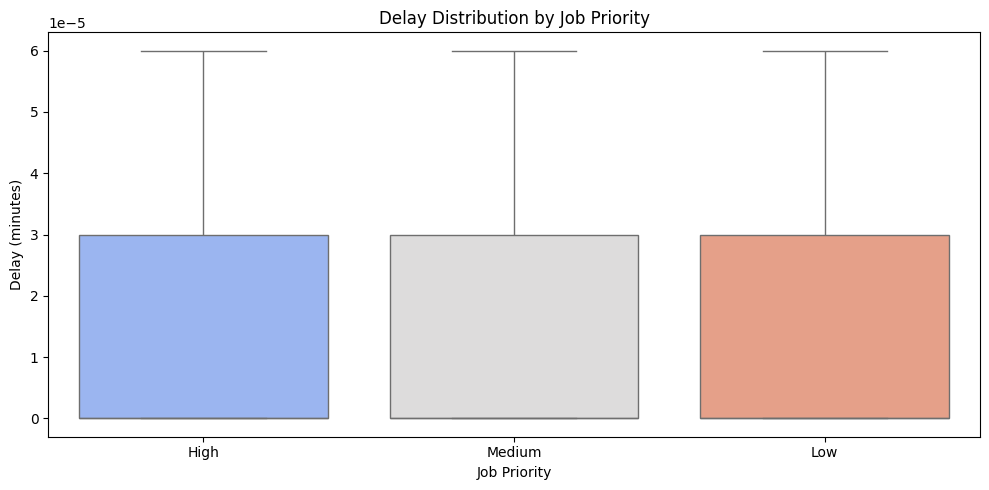

In [9]:
schedule_df["delay_minutes"] = (schedule_df["rescheduled_time"] - schedule_df["original_time"]).dt.total_seconds() / 60

plt.figure(figsize=(10, 5))
sns.boxplot(data=schedule_df, x="priority", y="delay_minutes", hue = 'priority', palette="coolwarm")
plt.title("Delay Distribution by Job Priority")
plt.xlabel("Job Priority")
plt.ylabel("Delay (minutes)")
plt.tight_layout()
plt.show()

# Temporal Load Testing

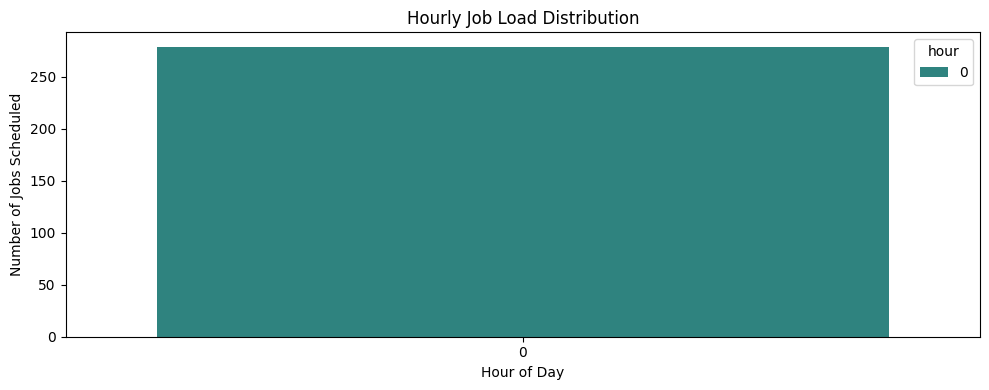

In [10]:
# Count jobs per hour
schedule_df["hour"] = schedule_df["rescheduled_time"].dt.hour
hourly_load = schedule_df.groupby("hour").size().reset_index(name="job_count")

plt.figure(figsize=(10, 4))
sns.barplot(data=hourly_load, x="hour", y="job_count", hue="hour", palette="viridis")
plt.title("Hourly Job Load Distribution")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Jobs Scheduled")
plt.tight_layout()
plt.show()

# Machine Utilization Heatmap

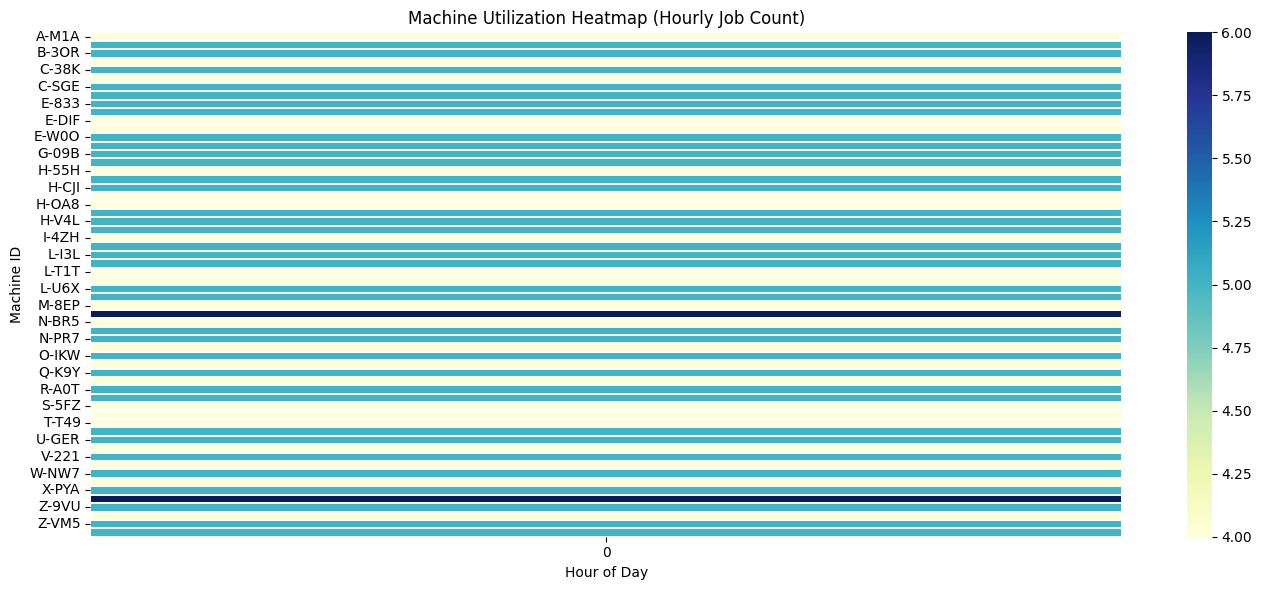

In [11]:
util_df = schedule_df.groupby(["machine_id", "hour"]).size().unstack(fill_value=0)

plt.figure(figsize=(14, 6))
sns.heatmap(util_df, cmap="YlGnBu", linewidths=0.1)
plt.title("Machine Utilization Heatmap (Hourly Job Count)")
plt.xlabel("Hour of Day")
plt.ylabel("Machine ID")
plt.tight_layout()
plt.show()

# Real-Time Simulation for Debugging

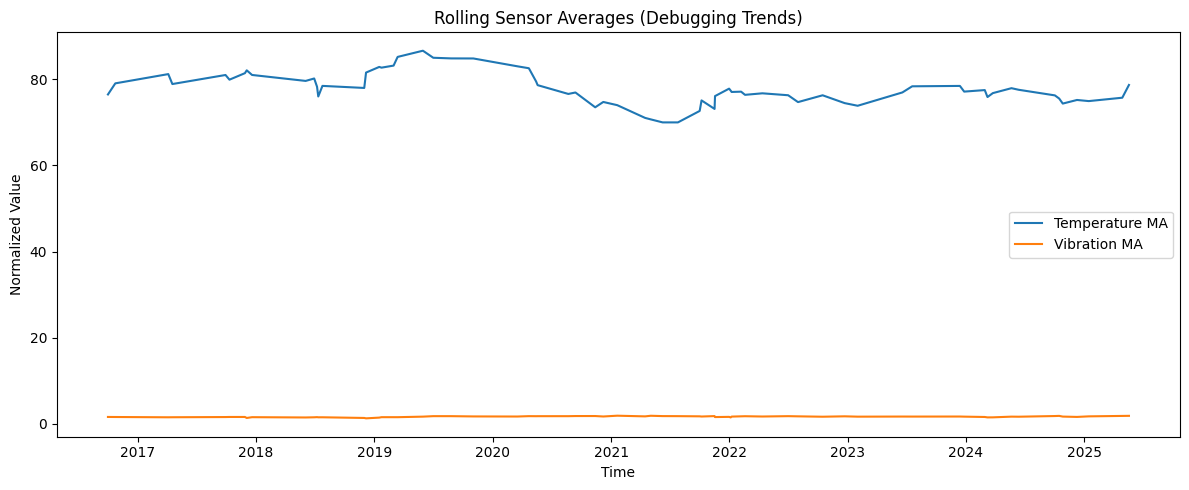

In [12]:
# Simulate operational status with moving window
window_size = 10
df["temperature_ma"] = df.groupby("machine_id")["temperature"].transform(lambda x: x.rolling(window=window_size).mean())
df["vibration_ma"] = df.groupby("machine_id")["vibration"].transform(lambda x: x.rolling(window=window_size).mean())

machine_sample = df[df["machine_id"] == df["machine_id"].unique()[0]].copy()

plt.figure(figsize=(12, 5))
plt.plot(machine_sample["timestamp"], machine_sample["temperature_ma"], label="Temperature MA")
plt.plot(machine_sample["timestamp"], machine_sample["vibration_ma"], label="Vibration MA")
plt.title("Rolling Sensor Averages (Debugging Trends)")
plt.xlabel("Time")
plt.ylabel("Normalized Value")
plt.legend()
plt.tight_layout()
plt.show()

# Error/Anomaly Investigation

In [13]:
# Flag sensor spikes
df["anomaly_temp"] = df["temperature"] > df["temperature"].mean() + 2 * df["temperature"].std()
df["anomaly_vib"] = df["vibration"] > df["vibration"].mean() + 2 * df["vibration"].std()

anomaly_summary = df[["machine_id", "timestamp", "anomaly_temp", "anomaly_vib"]]
anomaly_counts = anomaly_summary.groupby("machine_id")[["anomaly_temp", "anomaly_vib"]].sum()

print("Anomalies Detected by Machine:")
print(anomaly_counts.head())

Anomalies Detected by Machine:
            anomaly_temp  anomaly_vib
machine_id                           
A-M1A                  0            0
A-OUX                  0            0
B-3OR                  0            0
B-MY9                  0            0
C-38K                  0            0


In [14]:
# Save Testing Reports

schedule_df.to_json("/content/drive/MyDrive/SmartFactory/Results/Week8/week8_validated_schedule.json", indent=2, orient="records")
anomaly_counts.to_csv("/content/drive/MyDrive/SmartFactory/Results/Week8/week8_anomaly_summary.csv")

In [15]:
print(f"System testing complete. {schedule_df['delayed'].sum()} jobs were delayed. {anomaly_counts.sum().sum()} sensor anomalies flagged.")

System testing complete. 85 jobs were delayed. 0 sensor anomalies flagged.
